In [2]:
!pip install -U --pre tensorflow=="2.2.0"

     |████████████████████████████████| 516.2MB 34kB/s 
     |████████████████████████████████| 460kB 47.2MB/s 
     |████████████████████████████████| 2.9MB 32.8MB/s 
     |████████████████████████████████| 3.0MB 39.5MB/s 
  Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Found existing installation: tensorboard 2.5.0
    Uninstalling tensorboard-2.5.0:
      Successfully uninstalled tensorboard-2.5.0
  Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Found existing installation: tensorflow 2.5.0
    Uninstalling tensorflow-2.5.0:
      Successfully uninstalled tensorflow-2.5.0


In [3]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 2697, done.
remote: Counting objects: 100% (2697/2697), done.
remote: Compressing objects: 100% (2242/2242), done.
remote: Total 2697 (delta 682), reused 1224 (delta 421), pack-reused 0
Receiving objects: 100% (2697/2697), 32.68 MiB | 26.92 MiB/s, done.
Resolving deltas: 100% (682/682), done.


In [4]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp37-none-any.whl size=1654815 sha256=576c19c069fe898b7b04bae2cd5adde102f441bae11cef4778b64e307db3c25e
  Stored in directory: /tmp/pip-ephem-wheel-cache-3w0162c2/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
  Created wheel for avro-python3: filename=avro_python3-1.10.2-cp37-none-any.whl size=44011 sha256=b3a8f20c72d995c559502a29059b49ef2d61b8248be4dcc20021390ccc839f49
  Stored in directory: /root/.cache/pip/wheels/ee/ee/18/c466221ca6900e3efce2f4ea9c329288808679aecdcb2838d3
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491070 sha256=d772472dd3c29a3586899cf46dd7d5a72bf499bce0dad9d306bf9bf5f82483ce
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for dill: filename=dill-0.3.1.1-cp37-none-any.whl size=78545 sha256=d274d208f860d03c2fb666edb3e71e60fbc1939bfe343089d433

ERROR: multiprocess 0.70.11.1 has requirement dill>=0.3.3, but you'll have dill 0.3.1.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: apache-beam 2.30.0 has requirement avro-python3!=1.9.2,<1.10.0,>=1.8.1, but you'll have avro-python3 1.10.2 which is incompatible.


In [21]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage
import cv2
import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

In [15]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [34]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  # img_data = tf.io.gfile.GFile(path, 'rb').read()
  # image = Image.open(BytesIO(img_data))
  image = cv2.imread(path)
  image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
  (im_width, im_height,layer) = image.shape
  return image.astype(np.uint8)

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)

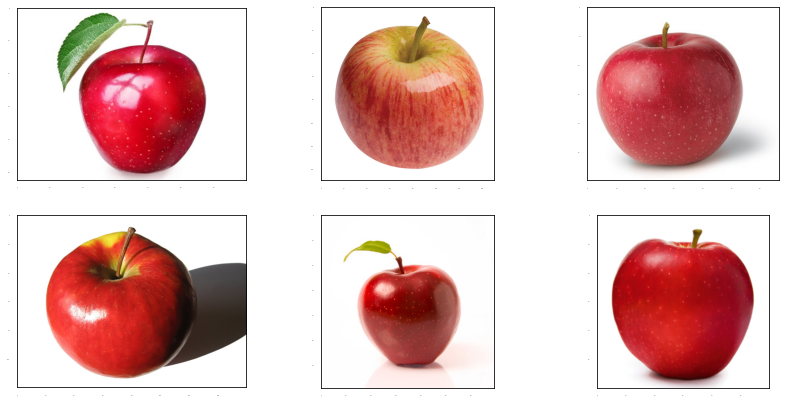

In [40]:
# Load images and visualize
train_image_dir = '/content/gdrive/My Drive/dataset/train/'
train_images_np = []
for i in range(2, 8):
  image_path = os.path.join(train_image_dir, 'apple_' + str(i) + '.jpg')
  train_images_np.append(load_image_into_numpy_array(image_path))

plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

for idx, train_image_np in enumerate(train_images_np):
  plt.subplot(2, 3, idx+1)
  plt.imshow(train_image_np)
plt.show()

In [41]:
gt_boxes = []
colab_utils.annotate(train_images_np, box_storage_pointer=gt_boxes)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

In [ ]:
gt_boxes = [
            np.array([[0.436, 0.591, 0.629, 0.712]], dtype=np.float32),
            np.array([[0.539, 0.583, 0.73, 0.71]], dtype=np.float32),
            np.array([[0.464, 0.414, 0.626, 0.548]], dtype=np.float32),
            np.array([[0.313, 0.308, 0.648, 0.526]], dtype=np.float32),
            np.array([[0.256, 0.444, 0.484, 0.629]], dtype=np.float32)
]

In [37]:
print(gt_boxes)

[array([[0.10333333, 0.04273504, 0.75833333, 0.44444444],
       [0.08666667, 0.43304843, 0.86      , 0.97435897]]), array([[0.025     , 0.16571429, 0.96666667, 0.82571429]]), array([[0.04333333, 0.07533333, 0.94      , 0.94133333]]), array([[0.08333333, 0.04504505, 0.925     , 0.81981982]]), array([[0.06666667, 0.121875  , 0.94666667, 0.786875  ]]), array([[0.14      , 0.12121212, 0.87166667, 0.81240981]]), array([[0.07666667, 0.06666667, 0.95833333, 0.91      ]])]


In [42]:
# By convention, our non-background classes start counting at 1.  Given
# that we will be predicting just one class, we will therefore assign it a
# `class id` of 1.
apple_class_id = 1
num_classes = 1

category_index = {apple_class_id: {'id': apple_class_id, 'name': 'apple'}}

# Convert class labels to one-hot; convert everything to tensors.
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
for (train_image_np, gt_box_np) in zip(
    train_images_np, gt_boxes):
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
      train_image_np, dtype=tf.float32), axis=0))
  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
  zero_indexed_groundtruth_classes = tf.convert_to_tensor(
      np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
  gt_classes_one_hot_tensors.append(tf.one_hot(
      zero_indexed_groundtruth_classes, num_classes))
print('Done prepping data.')

Done prepping data.


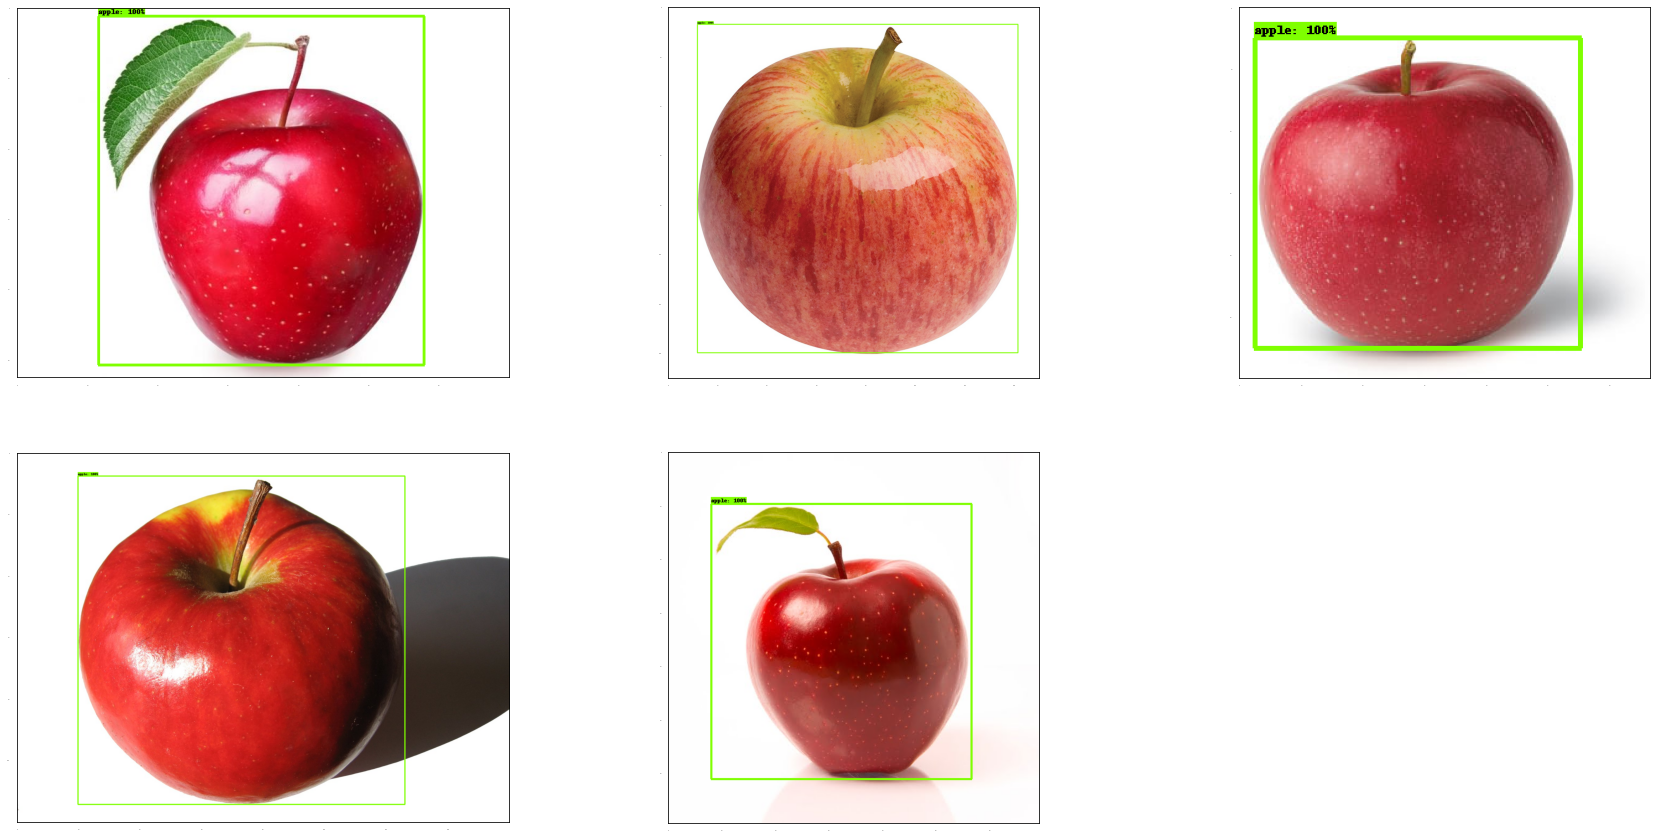

In [43]:
dummy_scores = np.array([1.0], dtype=np.float32)  # give boxes a score of 100%

plt.figure(figsize=(30, 15))
for idx in range(5):
  plt.subplot(2, 3, idx+1)
  plot_detections(
      train_images_np[idx],
      gt_boxes[idx],
      np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
      dummy_scores, category_index)
plt.show()

In [44]:
# Download the checkpoint and put it into models/research/object_detection/test_data/

!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2021-06-16 10:27:38--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.199.128, 2607:f8b0:400e:c08::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.199.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz.1’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M   207MB/s    in 1.1s    

2021-06-16 10:27:39 (207 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz.1’ saved [244817203/244817203]

mv: cannot move 'ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint' to 'models/research/object_detection/test_data/checkpoint': Directory not empty


In [45]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = 1
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'


configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=True)


fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,

    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()


image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...
Weights restored!


In [46]:
tf.keras.backend.set_learning_phase(True)


batch_size = 4
learning_rate = 0.01
num_batches = 100

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # Use tf.function for a bit of speed.
  # Comment out the tf.function decorator if you want the inside of the
  # function to run eagerly.
  @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

print('Start fine-tuning!', flush=True)
for idx in range(num_batches):
  # Grab keys for a random subset of examples
  all_keys = list(range(len(train_images_np)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]

  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
  image_tensors = [train_image_tensors[key] for key in example_keys]

  # Training step (forward pass + backwards pass)
  total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

  if idx % 10 == 0:
    print('batch ' + str(idx) + ' of ' + str(num_batches)
    + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:435: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


Start fine-tuning!
batch 0 of 100, loss=1.2708766
batch 10 of 100, loss=1.5271478
batch 20 of 100, loss=0.44689578
batch 30 of 100, loss=0.122647315
batch 40 of 100, loss=0.047986045
batch 50 of 100, loss=0.017631775
batch 60 of 100, loss=0.011625543
batch 70 of 100, loss=0.008846886
batch 80 of 100, loss=0.008374638
batch 90 of 100, loss=0.005723445
Done fine-tuning!


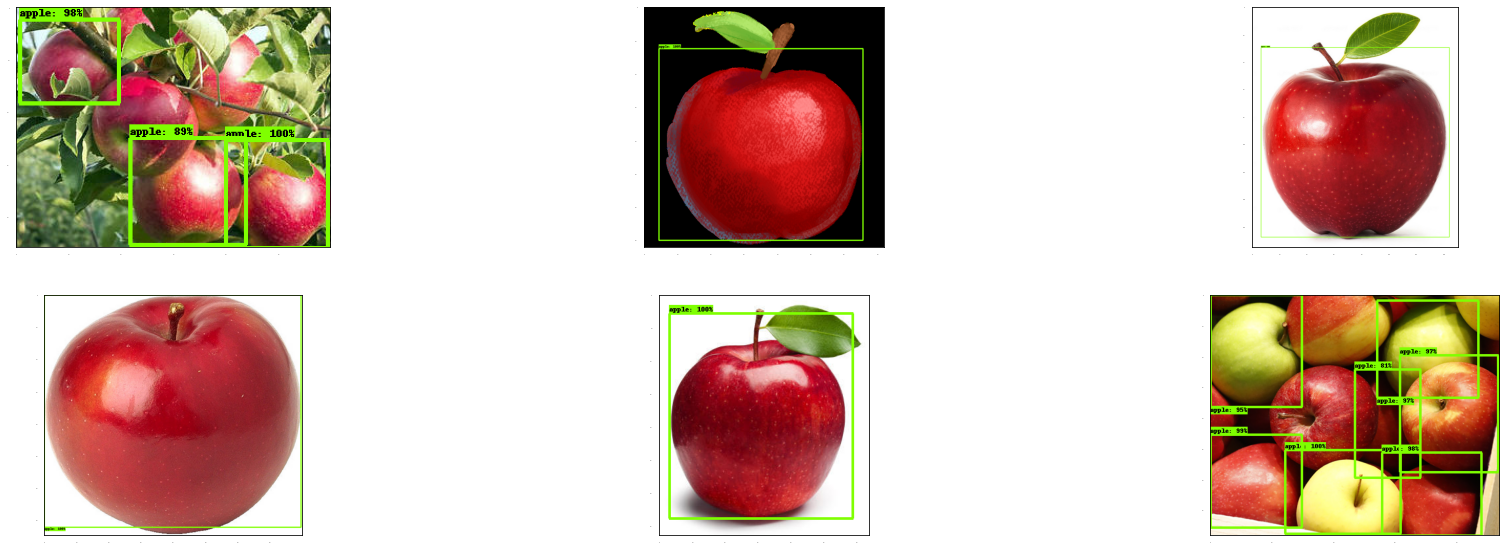

In [47]:
test_image_dir = '/content/gdrive/My Drive/dataset/test/'
test_images_np = []
for i in range(1, 7):
  image_path = os.path.join(test_image_dir, 'apple_0' + str(i) + '.jpg')
  test_images_np.append(np.expand_dims(
      load_image_into_numpy_array(image_path), axis=0))

# Again, uncomment this decorator if you want to run inference eagerly
@tf.function
def detect(input_tensor):
  """Run detection on an input image.

  Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  return detection_model.postprocess(prediction_dict, shapes)

# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.
plt.figure(figsize=(30, 15))
label_id_offset = 1
for i in range(len(test_images_np)):
  input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
  detections = detect(input_tensor)
  plt.subplot(3, 3, i+1)
  plot_detections(
      test_images_np[i][0],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32)
      + label_id_offset,
      detections['detection_scores'][0].numpy(),
      category_index, figsize=(15, 20))
plt.show()

In [ ]:
imageio.plugins.freeimage.download()

anim_file = 'duckies_test.gif'

filenames = glob.glob('gif_frame_*.jpg')
filenames = sorted(filenames)
last = -1
images = []
for filename in filenames:
  image = imageio.imread(filename)
  images.append(image)

imageio.mimsave(anim_file, images, 'GIF-FI', fps=5)

display(IPyImage(open(anim_file, 'rb').read()))

Output hidden; open in https://colab.research.google.com to view.